In [29]:
from tqdm import tqdm
from analysis.nlp_transformations import separate_previous_conversation, remove_footers
from typing import List
from dao.email import DAOEmailGenerated, DAORealEmail

from dao.attribute import DAOAttribute
from analysis.nlp_transformations import replace_links_with_text

In [30]:
from models.email import EmailGeneratedInDB
from analysis.attribute_retriving import calculate_burstiness
from analysis.nlp_transformations import lemmatize_text
from models.attribute import AttributeInDB

dao_generated_emails: DAOEmailGenerated = DAOEmailGenerated()
dao_real_emails: DAORealEmail = DAORealEmail()
dao_attribute: DAOAttribute = DAOAttribute()


all_attributes: List[AttributeInDB] = dao_attribute.find_many_by_query({'burstiness': None})
all_generated: List[AttributeInDB] = [attribute for attribute in all_attributes if attribute.referenced_db_name == 'email_generated_dataset']
all_real: List[AttributeInDB] = [attribute for attribute in all_attributes if attribute.referenced_db_name != 'email_generated_dataset']

generated_personal_emails: List[EmailGeneratedInDB] = dao_generated_emails.find_many_by_query({'possible_advertisement': {'$ne': True}})
real_personal_emails = [dao_real_emails.find_one(generated_email.og_db_name, generated_email.og_doc_id) for generated_email in generated_personal_emails]

generated_personal: List[AttributeInDB] = [dao_attribute.find_one_by_query({'referenced_doc_id': email.id}) for email in generated_personal_emails]
real_personal: List[AttributeInDB] = [dao_attribute.find_one_by_query({'referenced_doc_id': email.id}) for email in real_personal_emails]

In [31]:
generated_personal = [attribute for attribute in generated_personal if attribute is not None]
real_personal = [attribute for attribute in real_personal if attribute is not None]

In [32]:
pl_generated_personal = [attribute for attribute in generated_personal if attribute.language == 'pl']
pl_real_personal = [attribute for attribute in real_personal if attribute.language == 'pl']
en_generated_personal = [attribute for attribute in generated_personal if attribute.language == 'en']
en_real_personal = [attribute for attribute in real_personal if attribute.language == 'en']

In [33]:
from matplotlib import pyplot as plt
import numpy as np


def hist_attribute(data, title, num_bin = 10, max_value=5, min_value=0, metric_name="Metric"):
    data_to_plot = []
    for d in data:
        if d<max_value:
            data_to_plot.append(d)
        else:
            data_to_plot.append(max_value)

    w = (max_value-min_value)/num_bin
    plt.hist(data_to_plot, bins=np.arange(min_value, max_value + w, w))
    plt.title(title)
    plt.xlim([min_value, max_value])
    plt.xlabel(f'{metric_name} value')
    plt.ylabel('Number of emails')
    plt.show()
    
def compare_4_hists(attribute_name: str, min_value=None, max_value=None):
    data_pl_gen = [attribute.dict()[attribute_name] for attribute in pl_generated_personal]
    data_pl_real = [attribute.dict()[attribute_name] for attribute in pl_real_personal]
    data_en_gen = [attribute.dict()[attribute_name] for attribute in en_generated_personal]
    data_en_real = [attribute.dict()[attribute_name] for attribute in en_real_personal]
    if min_value is None:
        min_value = min(min(data_pl_gen), min(data_pl_real), min(data_en_gen), min(data_en_real))
    if max_value is None:
        max_value = max(max(data_pl_gen), max(data_pl_real), max(data_en_gen), max(data_en_real))
    hist_attribute(data_pl_gen, f'PL generated {attribute_name}', min_value=min_value, max_value=max_value, metric_name=attribute_name)
    hist_attribute(data_pl_real, f'PL real {attribute_name}', min_value=min_value, max_value=max_value, metric_name=attribute_name)
    hist_attribute(data_en_gen, f'EN generated {attribute_name}', min_value=min_value, max_value=max_value, metric_name=attribute_name)
    hist_attribute(data_en_real, f'EN real {attribute_name}', min_value=min_value, max_value=max_value, metric_name=attribute_name)

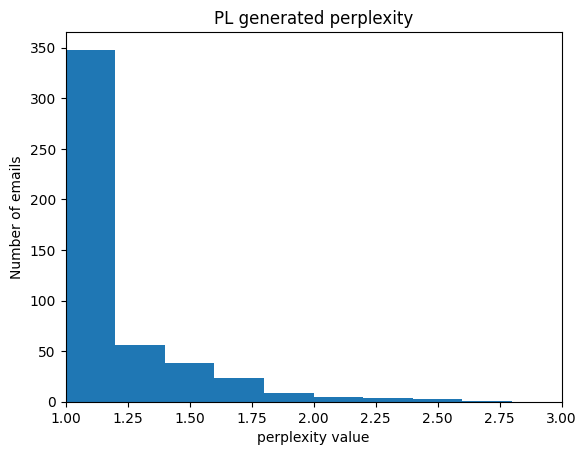

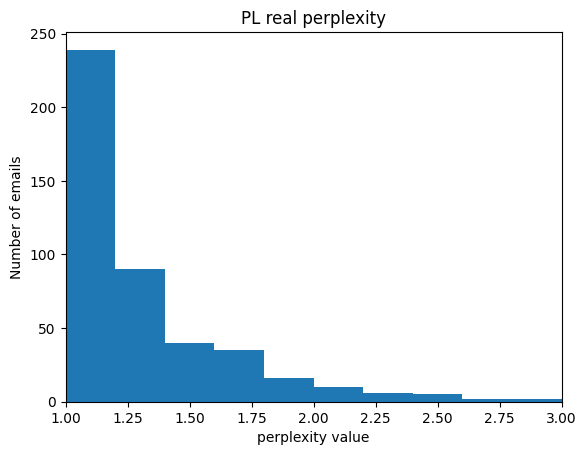

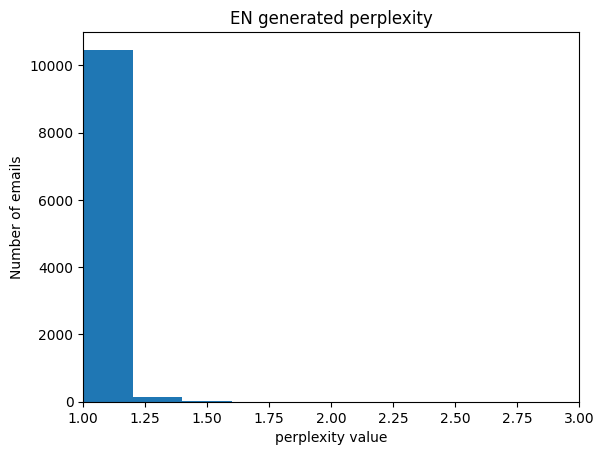

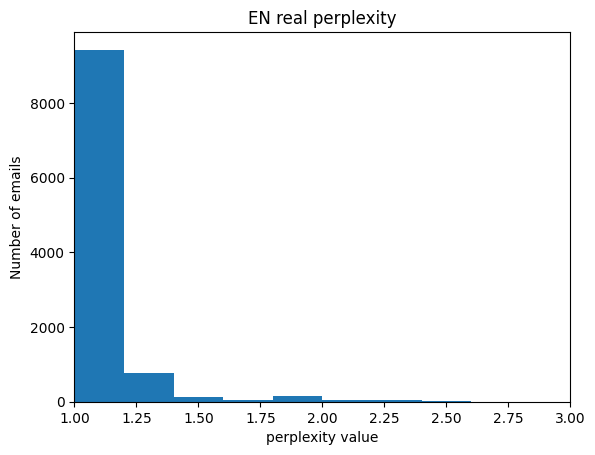

In [34]:
compare_4_hists('perplexity', min_value=1, max_value=3)

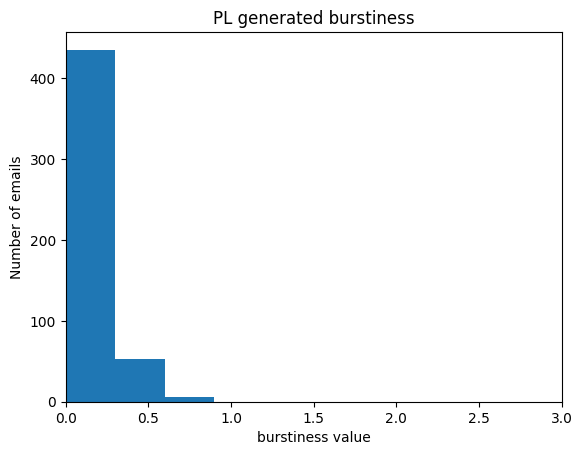

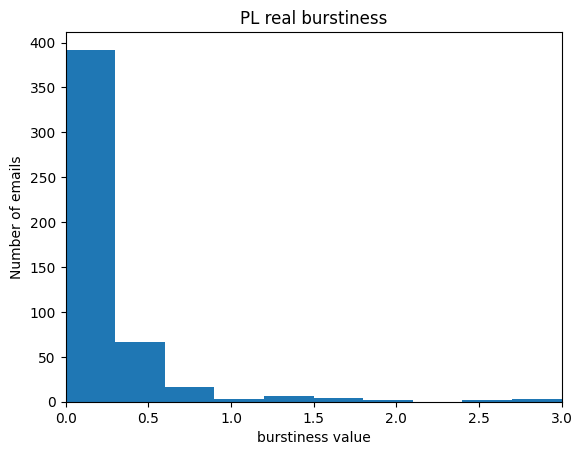

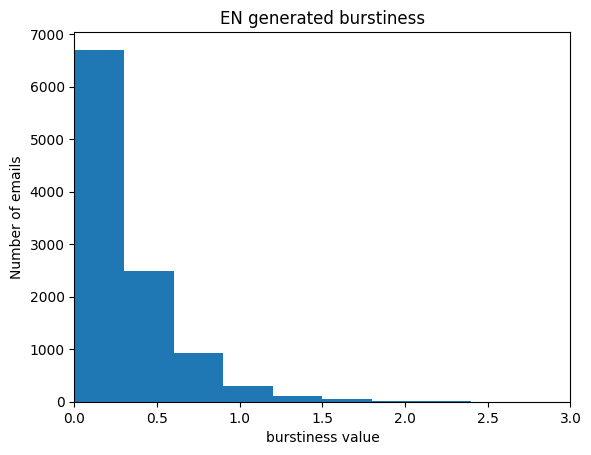

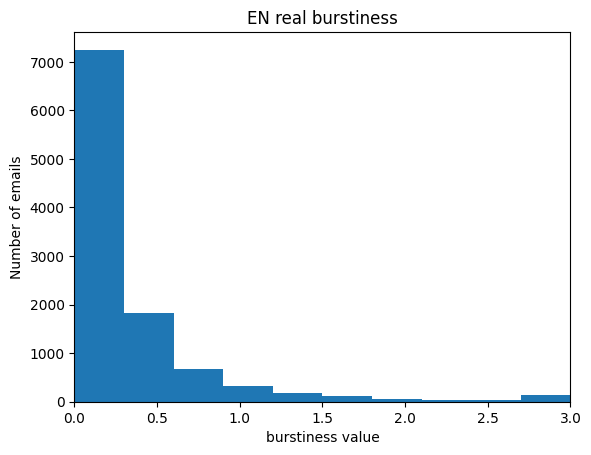

In [35]:
compare_4_hists('burstiness', min_value=0, max_value=3)

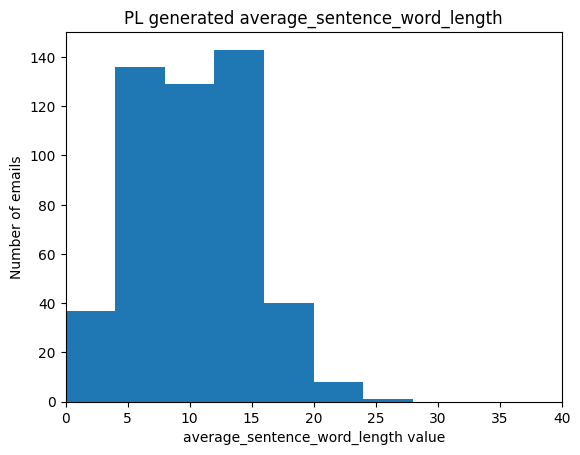

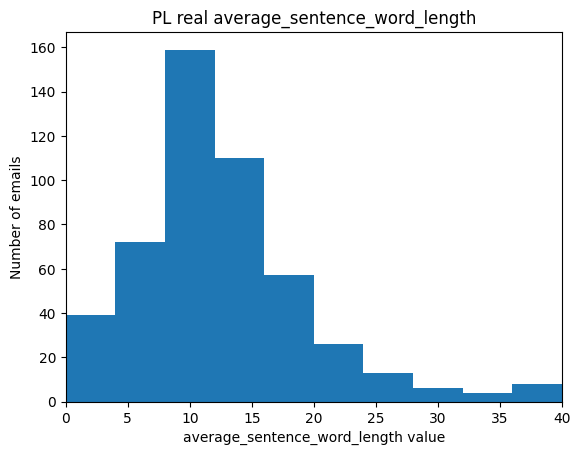

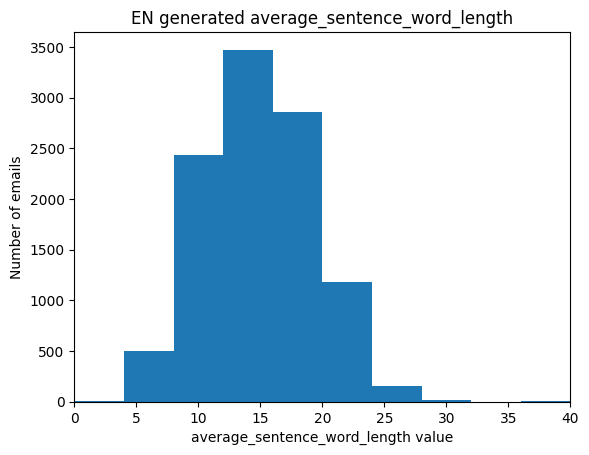

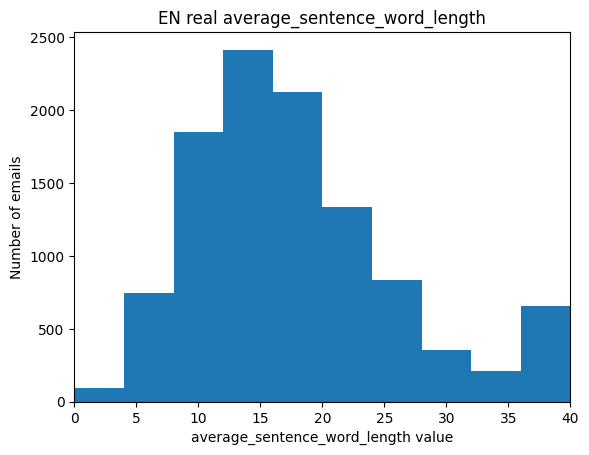

In [14]:
compare_4_hists('average_sentence_word_length', min_value=0, max_value=40)

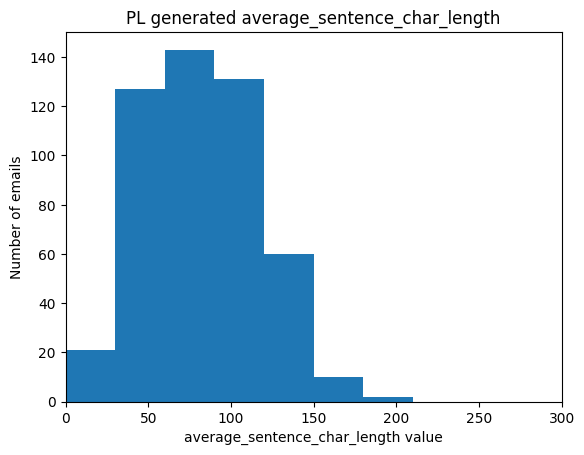

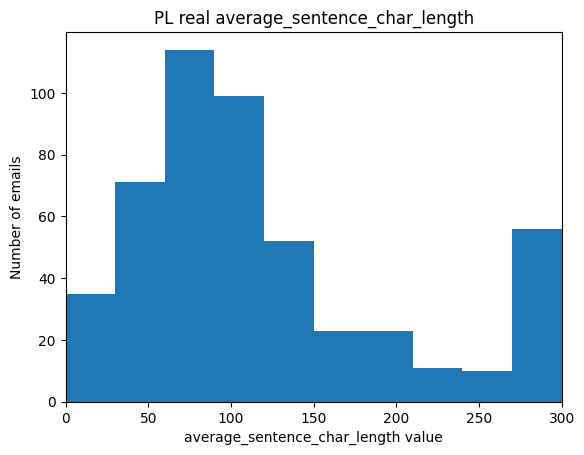

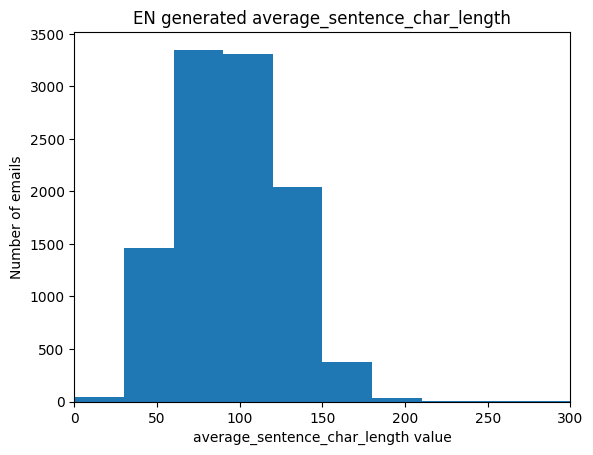

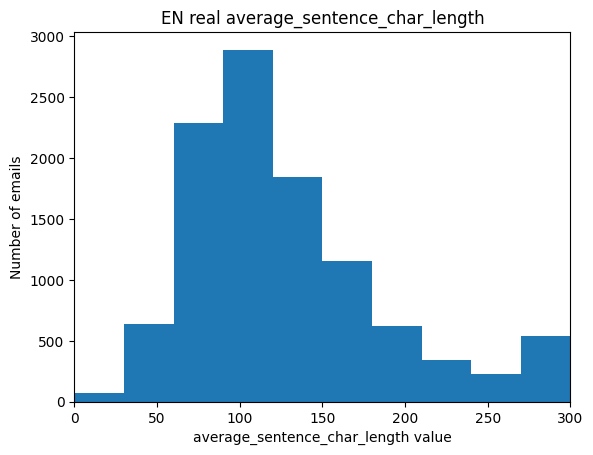

In [15]:
compare_4_hists('average_sentence_char_length', min_value=0, max_value=300)

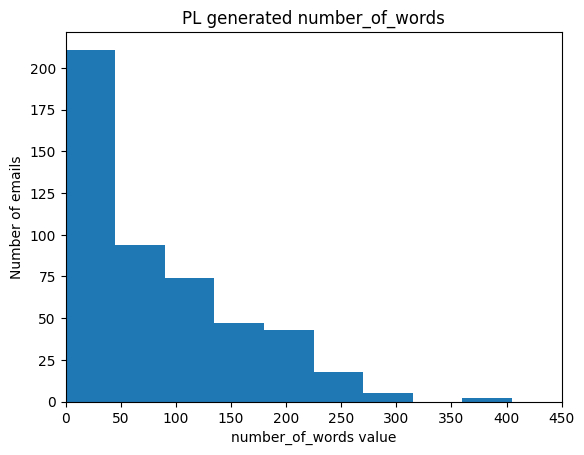

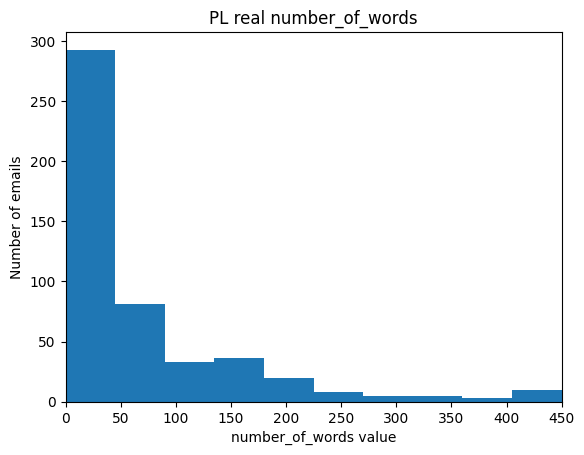

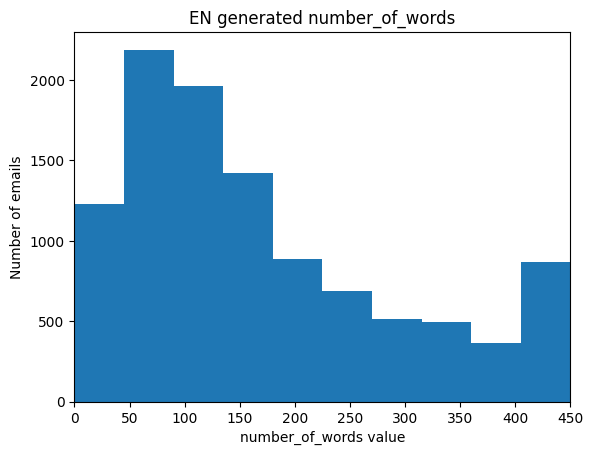

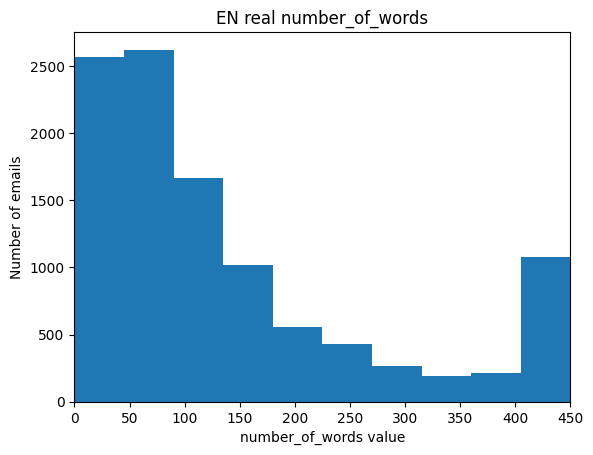

In [16]:
compare_4_hists('number_of_words', min_value=0, max_value=450)

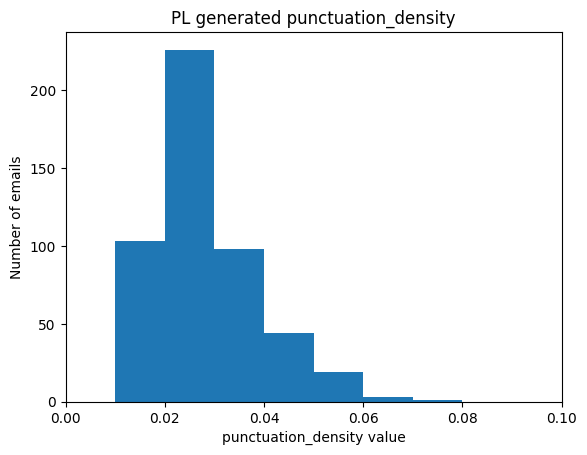

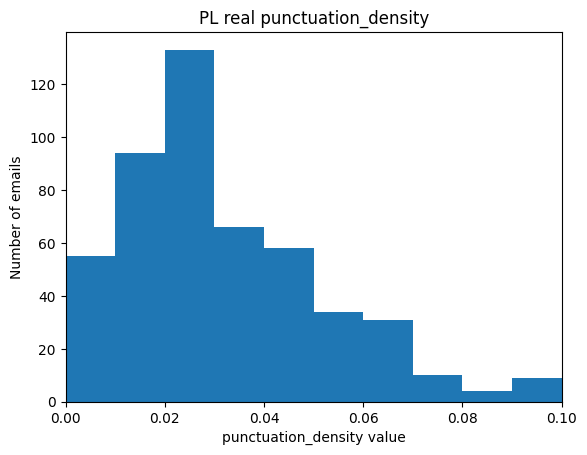

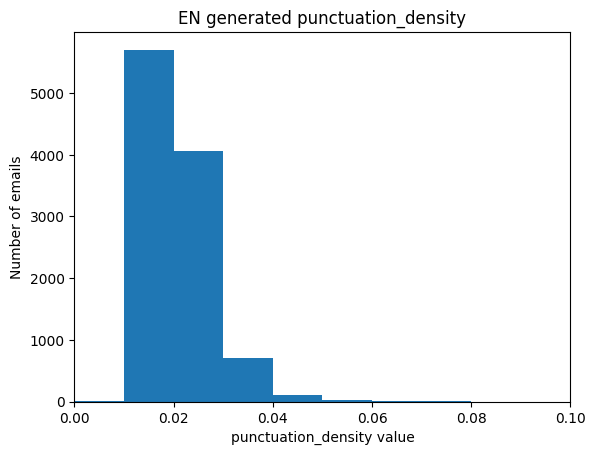

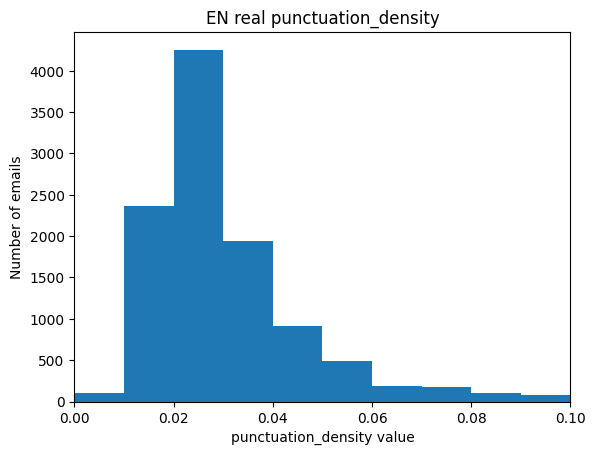

In [25]:
compare_4_hists('punctuation_density', min_value=0, max_value=0.1)

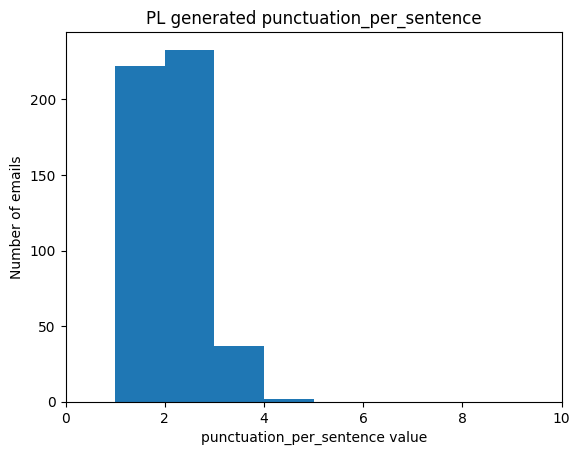

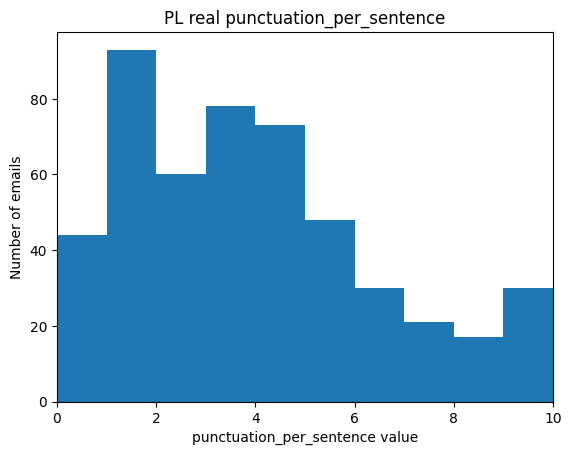

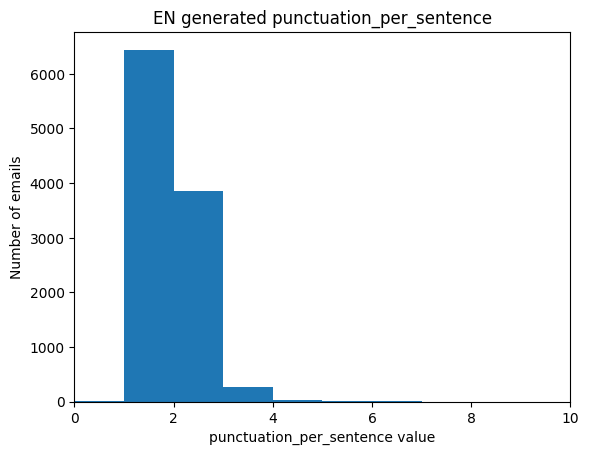

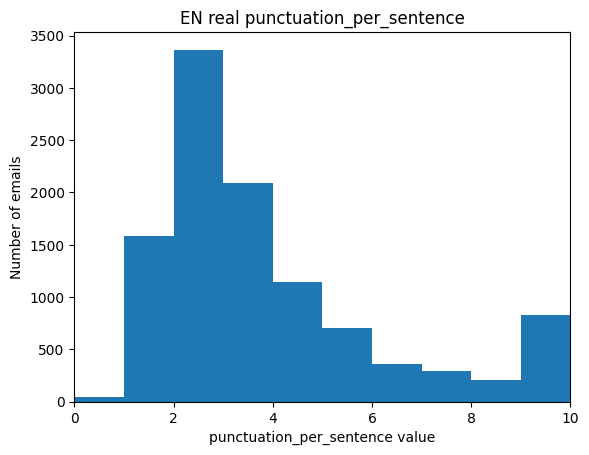

In [28]:
compare_4_hists('punctuation_per_sentence', min_value=0, max_value=10)